### Import libraries

In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:82.5% !important}</style>'))

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score

import eli5
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Paths to directories and files

In [5]:
TRAIN_DATASET_PATH = 'data/train_sessions.csv'
TEST_DATASET_PATH = 'data/test_sessions.csv'
SITE_DIC_PATH = 'data/site_dic.pkl'
RES_PATH = 'data/result_submission.csv'

### Loading data

In [6]:
times = ['time%s' % i for i in range(1, 11)]
train_df = pd.read_csv(TRAIN_DATASET_PATH, parse_dates=times) 
test_df = pd.read_csv(TEST_DATASET_PATH, parse_dates=times) 

In [7]:
train_df = train_df.sort_values(by='time1')

with open(SITE_DIC_PATH, 'rb') as f:
    site2id = pickle.load(f)
id2site = {v:k for (k, v) in site2id.items()}
id2site[0] = 'unknown'

sites = ['site%s' % i for i in range(1, 11)]

train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                 ' '.join([id2site[i] for i in row]), axis=1).tolist()

test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                 ' '.join([id2site[i] for i in row]), axis=1).tolist()

vectorizer_params = {'ngram_range': (1, 2), 
                     'max_features': 115000,
                     'analyzer': 'word', 
                     'tokenizer': lambda s: s.split()}

vectorizer = TfidfVectorizer(**vectorizer_params) 

X = vectorizer.fit_transform(train_sessions)
y = train_df['target'] 

test = vectorizer.transform(test_sessions)

train_times, test_times = train_df[times], test_df[times]

### Functions

In [8]:
# Функция для записи предсказаний в файл
def write_to_submission_file(predicted_labels, out_file, target='target', index_label='session_id'):
    predicted_df = pd.DataFrame(predicted_labels, index = np.arange(1, predicted_labels.shape[0] + 1), columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

### Exploratory Data Analysis

In [9]:
session_start_hour = train_times['time1'].apply(lambda ts: ts.hour).values

Text(0.5, 0, 'Session start hour')

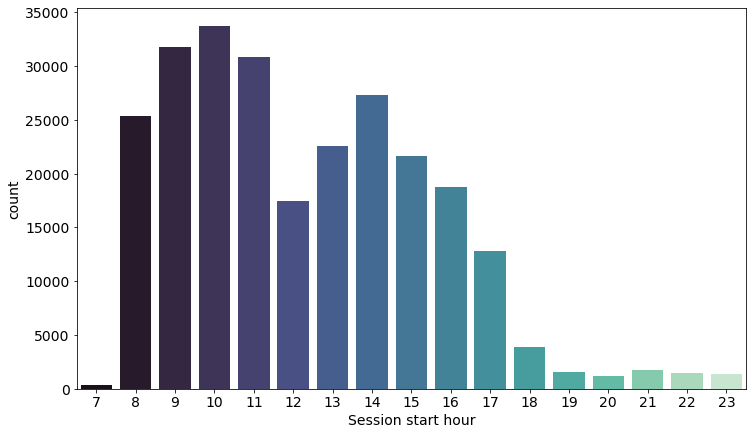

In [10]:
plt.subplots(figsize=(12, 7)) 
sns.countplot(session_start_hour, palette='mako')
plt.xlabel('Session start hour')

Text(0.5, 0, 'Session start hour')

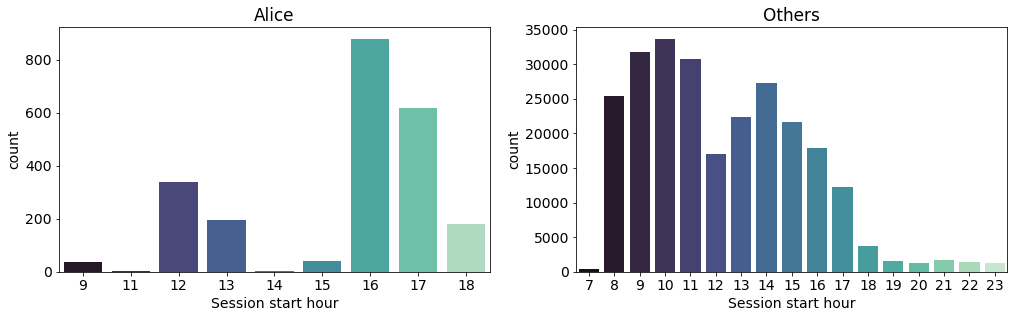

In [11]:
plt.subplots(1, 2, figsize = (17, 4.5)) 

plt.subplot(1, 2, 1)
sns.countplot(session_start_hour[y == 1], palette='mako')
plt.title('Alice')
plt.xlabel('Session start hour')
          
plt.subplot(1, 2, 2)
sns.countplot(session_start_hour[y == 0], palette='mako')
plt.title('Others')
plt.xlabel('Session start hour')

### Feature engineering

In [12]:
morning = ((session_start_hour >= 7) & (session_start_hour <= 11)).astype('int')
day = ((session_start_hour >= 12) & (session_start_hour <= 18)).astype('int')
evening = ((session_start_hour >= 19) & (session_start_hour <= 23)).astype('int')
night = ((session_start_hour >= 0) & (session_start_hour <= 6)).astype('int')

In [13]:
def add_time_features(times, X_sparse):
    hour = times['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 7) & (hour <= 11)).astype('int').values.reshape(-1, 1)
    day = ((hour >= 12) & (hour <= 18)).astype('int').values.reshape(-1, 1)
    evening = ((hour >= 19) & (hour <= 23)).astype('int').values.reshape(-1, 1)
    night = ((hour >= 0) & (hour <=6)).astype('int').values.reshape(-1, 1)
    
    objects_to_hstack = [X_sparse, morning, day, evening, night]
    feature_names = ['morning', 'day', 'evening', 'night']
    
    X = hstack(objects_to_hstack)
    return X, feature_names

In [14]:
%%time
X, new_feat_names = add_time_features(train_times, X)
test, _ = add_time_features(test_times, test)

Wall time: 2.22 s


### Масштабирование признаков

In [15]:
train_durations = (train_times.max(axis=1) - train_times.min(axis=1)).astype('timedelta64[ms]').astype(int)
test_durations = (test_times.max(axis=1) - test_times.min(axis=1)).astype('timedelta64[ms]').astype(int)

scaler = StandardScaler()
train_dur_scaled = scaler.fit_transform(train_durations.values.reshape(-1, 1))
test_dur_scaled = scaler.transform(test_durations.values.reshape(-1, 1))

In [16]:
X = hstack([X, train_dur_scaled])
test = hstack([test, test_dur_scaled])

### Feature engineering

In [17]:
def add_day_month(times, X_sparse):
    day_of_week = times['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
    month = times['time1'].apply(lambda t: t.month).values.reshape(-1, 1) 
    year_month = times['time1'].apply(lambda t: 100 * t.year + t.month).values.reshape(-1, 1) / 1e5 # 100000
    
    objects_to_hstack = [X_sparse, day_of_week, year_month]
    feature_names = ['day_of_week', 'year_month']    
        
    X = hstack(objects_to_hstack)
    return X, feature_names

In [18]:
X, more_feat_names = add_day_month(train_times, X)
test, _ = add_day_month(test_times, test)

### LogisticRegression

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17, shuffle=True)

model_lr = LogisticRegression(C=25, random_state=17, solver='lbfgs', multi_class='multinomial', max_iter=205)
model_lr.fit(X_train, y_train)

train_predictions_lr = model_lr.predict_proba(X_train)[:, 1]
test_predictions_lr = model_lr.predict_proba(X_test)[:, 1]

train_score = roc_auc_score(y_train, train_predictions_lr)
test_score = roc_auc_score(y_test, test_predictions_lr)
                            
print(f'Train mean score: {round(np.mean(train_score), 5)}, Test mean score: {round(np.mean(test_score), 5)}')

Train mean score: 0.99621, Test mean score: 0.98094


### VotingClassifier

In [20]:
model_lr = LogisticRegression(C=1, random_state=17, solver='liblinear')
model_lr2 = LogisticRegression(C=2, random_state=17, solver='lbfgs', multi_class='multinomial', max_iter=190)
model_lr3 = LogisticRegression(C=3, random_state=17, solver='lbfgs', multi_class='multinomial', max_iter=190)
# model_lr4 = LogisticRegression(C=25, random_state=17, solver='lbfgs', multi_class='multinomial', max_iter=205)

model_vc = VotingClassifier(estimators=[('LogisticRegression', model_lr), ('LogisticRegression2', model_lr2), 
                                        ('LogisticRegression3', model_lr3)], voting='soft')

In [21]:
model_vc.fit(X_train, y_train)

train_predictions_vc = model_vc.predict_proba(X_train)[:, 1]
test_predictions_vc = model_vc.predict_proba(X_test)[:, 1]

train_score2 = roc_auc_score(y_train, train_predictions_vc)
test_score2 = roc_auc_score(y_test, test_predictions_vc)

print(f'Train mean score: {round(np.mean(train_score2), 5)}, Test mean score: {round(np.mean(test_score2), 5)}')

Train mean score: 0.98993, Test mean score: 0.97808


### Result

In [22]:
test_pred = model_vc.predict_proba(test)[:, 1]

In [23]:
write_to_submission_file(test_pred, RES_PATH) 